<a href="https://colab.research.google.com/github/Moniapolimi/Moniapolimi/blob/main/Fracture_Classification_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Musculoskeletal Radiographs Abnormality Detection**

# **Exploratory Data Analysis**

### **Problem**

Determining whether a radiographic study is normal or abnormal is a critical radiological task: a study interpreted as normal rules out disease and can eliminate the need for patients to undergo further diagnostic procedures or interventions. The musculoskeletal abnormality detection task is particularly critical as more than 1.7 billion people are affected by musculoskeletal conditions worldwide (BMU, 2017). These conditions are the most common cause of severe, long-term pain and disability (Woolf & Pfleger, 2003), with 30 million emergency department visits annually and increasing. Our dataset, MURA, contains 9,045 normal and 5,818 abnormal musculoskeletal radiographic studies of the upper extremity including the shoulder, humerus, elbow, forearm, wrist, hand, and finger. MURA is one of the largest public radiographic image datasets. More information about the  the dataset can be found [here](http://stanfordmlgroup.github.io/competitions/mura/)  as well as [in this paper](http://https://arxiv.org/pdf/1712.06957.pdf)

# Libraries

In [ ]:
%%bash
pip install keras-adabound
pip install tensorflow_addons

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for keras-adabound: filename=keras_adabound-0.6.0-py3-none-any.whl size=6589 sha256=df87383f90c86e30ac02f716822f2c220bee69b7ddb69e925e29baaffa511c53
  Stored in directory: /root/.cache/pip/wheels/c7/0c/82/026bbf0810e0ac6d6b6686fef3891d052534ecb440a0c28c19
Successfully built keras-adabound
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.2.1
    Uninstalling typeguard-4.2.1:
      Successfully uninstalled typeguard-4.2.1


In [ ]:
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 703.4 kB/s eta 0:00:00


In [ ]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from enum import Enum
import cv2
from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
import gc
from tensorflow.keras.utils import to_categorical
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam
from keras_adabound import AdaBound
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Input, Conv2D,BatchNormalization
from tensorflow.keras.layers import Activation,SpatialDropout2D,AvgPool2D
from tensorflow.keras.layers import MaxPool2D,Dropout,GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D,Flatten,Dropout,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow_addons.metrics import CohenKappa
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import DenseNet121,DenseNet169,DenseNet201
from tensorflow.keras.models import load_model
from numpy import dstack
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# define seed number to have reproducible experiments.
seed = 3352024
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# Load data

This data comes as split dataset (training & validation in separate directories). Each data categories such as training & validation has sub-directories (pls see below).


```

└─train {data category}
│   └───XR_ELBOW {study type}
│       │  └───patient00011 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {radiographs}
│       │               └───image2.png
│       │               └───image3.png
                        └───...
   ...
   

└─valid {data category}
│   └───XR_HUMERUS {study type}
│       │  └───patient11216 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {radiographs}
│       │               └───image2.png
                        └───...
```

### Helper Function for loading dataset

In [ ]:
def load_path(path):

    '''
    load MURA dataset
    '''
    dataset = []
    for body in os.listdir(path):
        body_part = body
        path_p = path+'/'+str(body)
        for id_p in os.listdir(path_p):
            patient_id = id_p
            path_id = path_p+'/'+str(id_p)
            for lab in os.listdir(path_id):
                if lab.split('_')[-1]=='positive':
                    label = 1
                elif lab.split('_')[-1]=='negative':
                    label= 0
                path_l = path_id+'/'+str(lab)
                for img in os.listdir(path_l):
                    img_path = path_l + '/' + str(img)
                    dataset.append(
                        {
                            'body_part': body_part,
                            'patient_id': patient_id,
                            'label': label,
                            'img_path': img_path
                        }
                    )
    return dataset

In [ ]:
path = '/content/drive/MyDrive/SmartHospital_PrecisionMedicine/Challenge_2024/MURA-v1.1/train'   # change this path with your location after mounted your drive
os.listdir(path)

['XR_WRIST',
 'XR_FOREARM',
 'XR_FINGER',
 'XR_HUMERUS',
 'XR_ELBOW',
 'XR_SHOULDER',
 'XR_HAND']

**Train set**

In [ ]:
dataset = load_path(path)
df_train = pd.DataFrame(dataset)
df_train.head()

In [ ]:
dataset_test = load_path(path = '/content/drive/MyDrive/SmartHospital_PrecisionMedicine/Challenge_2024/MURA-v1.1/valid') # change this path with your location
df_test = pd.DataFrame(dataset_test)
df_test.head()

,body_part,patient_id,label,img_path
0,XR_HUMERUS,patient11214,1,../input/mura-v11/MURA-v1.1/valid/XR_HUMERUS/p...
1,XR_HUMERUS,patient11214,1,../input/mura-v11/MURA-v1.1/valid/XR_HUMERUS/p...
2,XR_HUMERUS,patient11690,0,../input/mura-v11/MURA-v1.1/valid/XR_HUMERUS/p...
3,XR_HUMERUS,patient11690,0,../input/mura-v11/MURA-v1.1/valid/XR_HUMERUS/p...
4,XR_HUMERUS,patient11689,0,../input/mura-v11/MURA-v1.1/valid/XR_HUMERUS/p...


## Data Preprocessing

#### Creating Dataset for the Model traing and generating Labels for the same.

**Training set**

In [ ]:
#csv files path
path = '/content/drive/MyDrive/SmartHospital_PrecisionMedicine/Challenge_2024/MURA-v1.1' # change this path with your location
train_image_paths_csv = "train_image_paths.csv"

In [ ]:
train_images_paths = pd.read_csv(os.path.join(path,train_image_paths_csv),dtype=str,header=None)
train_images_paths.columns = ['image_path']

In [ ]:
train_images_paths['label'] = train_images_paths['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
train_images_paths['category']  = train_images_paths['image_path'].apply(lambda x: x.split('/')[2])
train_images_paths['patientId']  = train_images_paths['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))
train_images_paths.head()

,image_path,label,category,patientId
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002


**Test set**

In [ ]:
path = '../input/mura-v11/MURA-v1.1'
valid_image_paths_csv = "valid_image_paths.csv"
valid_data_paths = pd.read_csv(os.path.join(path,valid_image_paths_csv),dtype=str,header=None)
valid_data_paths.columns = ['image_path']

In [ ]:
valid_data_paths['label'] = valid_data_paths['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
valid_data_paths['category']  = valid_data_paths['image_path'].apply(lambda x: x.split('/')[2])
valid_data_paths['dir'] =  valid_data_paths['image_path'].apply(lambda x: x.split('/')[1])
valid_data_paths['patientId']  = valid_data_paths['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))
valid_data_paths.head()

,image_path,label,category,dir,patientId
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,positive,XR_WRIST,valid,11186


In [ ]:
train_images_paths['label_index']= train_images_paths.label

In [ ]:
train_images_paths.label_index.replace('positive', 1, inplace=True)
train_images_paths.label_index.replace('negative', 0, inplace=True)
train_images_paths.head(3)

,image_path,label,category,patientId,label_index
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,1


In [ ]:
valid_data_paths['label_index']= valid_data_paths.label
valid_data_paths.label_index.replace('positive', 1, inplace=True)
valid_data_paths.label_index.replace('negative', 0, inplace=True)
valid_data_paths.head(3)

,image_path,label,category,dir,patientId,label_index
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185,1


## Image Preprocessing for creation of Dataset.

In [ ]:
im_size = 256

#### Random Rotation flip

In [ ]:
def random_rotation_flip(image,size = 256):
    if random.randint(0,1):
        image = cv2.flip(image,1) # 1-->horizontal flip 0-->Vertical flip -1-->Horizontal and vertical

    if random.randint(0,1):
            angle = random.randint(-30,30)
            M = cv2.getRotationMatrix2D((size/2,size/2),angle,1)
            #The third parameter: the size of the transformed image
            image = cv2.warpAffine(image,M,(size,size))
    return image

#### Image / Dataset Loader with random rotation flip

In [ ]:
def image_loader(Path, size = 224):
    Images = []
    for path in tqdm(Path):
        try:
            image = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image,(size,size))
            image = random_rotation_flip(image,size)
            Images.append(image)
        except Exception as e:
            print(str(e))
    Images = np.asarray(Images).astype('float32')
    mean = np.mean(Images)
    std = np.std(Images)
    Images = (Images - mean) / std

    return Images

**Train set**

In [ ]:
X_train = image_loader(train_images_paths['image_path'][:50,],im_size)

100%|██████████| 50/50 [00:00<00:00, 268.09it/s]


In [ ]:
y_train = train_images_paths['label']

In [ ]:
Y_train = y_train.replace("positive",1)
Y_train = Y_train.replace("negative",0)

**Test set**

In [ ]:
X_test = image_loader(valid_data_paths['image_path'][:50,],im_size)

100%|██████████| 50/50 [00:00<00:00, 374.62it/s]


In [ ]:
y_test = valid_data_paths['label']

In [ ]:
Y_test = y_test.replace("positive",1)
Y_test = Y_test.replace("negative",0)

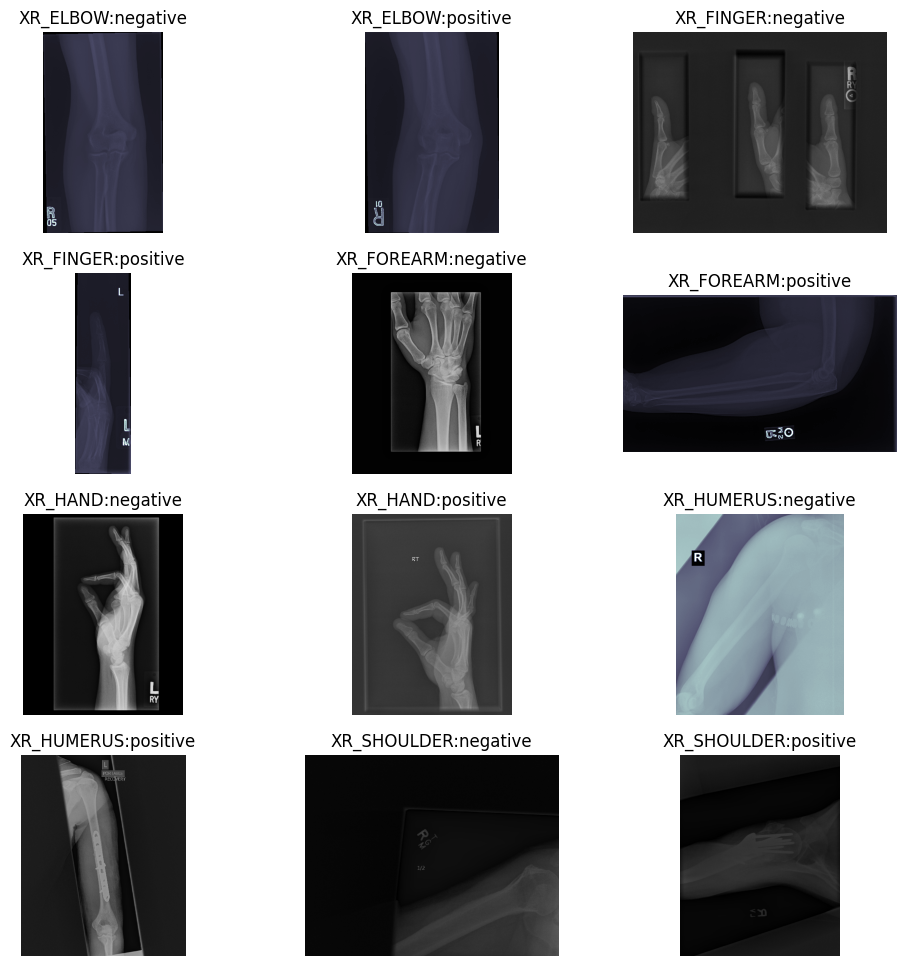

In [ ]:
from skimage.io import imread
sub_df = train_images_paths.groupby(['category', 'label']).apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, (m_axs) = plt.subplots(4, sub_df.shape[0]//4, figsize = (12, 12))
for c_ax, (_, c_row) in zip(m_axs.flatten(), sub_df.iterrows()):
    c_ax.imshow(imread(c_row['image_path']), cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title('{category}:{label}'.format(**c_row))

In [ ]:
train, valid = train_test_split(train_images_paths, test_size=0.2,random_state=seed)

In [ ]:
test = valid_data_paths.drop(['dir'], axis=1)

## Dataset Preparation

> [NOTE : We wont be doing image augmentations in this notebook , we will do that in other Notebook to see how it impacts accuracy of models]

In [ ]:
image_generator_settings = dict(
                          rescale = 1. / 255,
                          #samplewise_center = True,
                          #samplewise_std_normalization = True
                          #rotation_range = 5,
                         )
image_generator = ImageDataGenerator(**image_generator_settings)

In [ ]:
path = 'MURA-v1.1'

In [ ]:
train_generator = image_generator.flow_from_dataframe(dataframe = train,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = True,class_mode = 'raw', target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest',validate_filenames=False,seed=seed)
valid_generator = image_generator.flow_from_dataframe(dataframe = valid,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = True,class_mode = 'raw',target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest',validate_filenames=True,seed=seed)
test_generator = image_generator.flow_from_dataframe(dataframe = test,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = False,class_mode = 'raw', target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest', validate_filenames=True,seed=seed)

Found 29446 non-validated image filenames.
Found 7362 validated image filenames.
Found 3197 validated image filenames.


In [ ]:
CLASSES = 2
input_shape = (im_size,im_size,3)

#### Helper function for Multiple Metrics for Evaluation of our model

In [ ]:
def metrics():
    return [
        AUC(name="auc"),
        BinaryAccuracy("accuracy"),
        CohenKappa(name="kappa", num_classes=2)
    ]

#### Custom function for Plotting results for our model in various stages

In [ ]:
def plot_history(hs, epochs, metric):
    if metric=='loss':
                label_y = 'Loss'
    elif metric=='accuracy':
               label_y = 'Accuracy'
    elif metric=='auc':
               label_y = 'AUC'
    else : label_y = 'kappa'
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel(label_y)
    plt.legend()
    plt.show()

def print_results(model_name,epochs,hs,model_eval):
    print("Train Loss     : {0:.5f}".format(hs.history['loss'][-1]))
    print("Validation Loss: {0:.5f}".format(hs.history['val_loss'][-1]))
    print("Test Loss      : {0:.5f}".format(model_eval[0]))
    print("---")
    print("Train AUC     : {0:.5f}".format(hs.history['auc'][-1]))
    print("Validation AUC: {0:.5f}".format(hs.history['val_auc'][-1]))
    print("Test AUC      : {0:.5f}".format(model_eval[1]))
    print("---")
    print("Train Accuracy     : {0:.5f}".format(hs.history['accuracy'][-1]))
    print("Validation Accuracy: {0:.5f}".format(hs.history['val_accuracy'][-1]))
    print("Test Accuracy      : {0:.5f}".format(model_eval[2]))
    print("---")
    print("Train Kappa     : {0:.5f}".format(hs.history['kappa'][-1]))
    print("Validation Kappa: {0:.5f}".format(hs.history['kappa'][-1]))
    print("Test Kappa      : {0:.5f}".format(model_eval[3]))
    # Plot train and validation error per epoch.
    plot_history(hs={model_name: hs}, epochs=epochs, metric='loss')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='auc')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='accuracy')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='kappa')

#### Helper function to clear Memory Utilization enabling it to Work with GPU and standard RAM allowance in Kaggle.

In [ ]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect() #garbage collection
    print("...Finished clean up...")

## Training Models DCNN Models having Different Architectures

### Model 1 : Basic CNN Architecture

In [ ]:
def cnn_builder(
        input_shape=(256, 256, 3),
        starting_filters=32,
        conv_layers=1,
        conv_strides=(1, 1),
        conv_kernel=(3, 3),
        convs_per_layer=1,
        batch_norm=False,
        pooling="max",
        dropout=None,
        pool_size=(2, 2),
        pool_strides=(2, 2),
        last_pooling=None,
        spatial_dropout=None,
        last_dropout=None,
):
    inputs = Input(
        shape=input_shape,
        name="input"
    )
    x = inputs
    for conv_level in range(conv_layers):
        current_filters = starting_filters * (2 ** conv_level)
        for conv_number in range(convs_per_layer):
            x = Conv2D(
                filters=current_filters,
                kernel_size=conv_kernel,
                strides=conv_strides,
                name=f"conv_{conv_level}_{conv_number}",
                padding='same'
            )(x)
            if batch_norm:
                x = BatchNormalization(name=f"bn_{conv_level}_{conv_number}")(x)
            x = Activation("relu", name=f"conv_{conv_level}_{conv_number}_relu")(x)
        if spatial_dropout:
            x = SpatialDropout2D(spatial_dropout, name=f"sp_dropout_{conv_level}")(x)
        if pooling == 'avg':
            x = AvgPool2D(pool_size=pool_size,
                          strides=pool_strides,
                          name=f"mp_{conv_level}",
                          padding='same')(x)
        elif pooling == 'max':
            x = MaxPool2D(pool_size=pool_size,
                          strides=pool_strides,
                          name=f"mp_{conv_level}",
                          padding='same')(x)
        if dropout:
            x = Dropout(dropout, name=f"dropout_{conv_level}")(x)
    if last_pooling == "avg":
        x = GlobalAveragePooling2D(name=f"lp_{last_pooling}")(x)
    elif last_pooling == "max":
        x = GlobalMaxPooling2D(name=f"lp_{last_pooling}")(x)
    x = Flatten(name="flatten")(x)
    if last_dropout:
        x = Dropout(last_dropout, name="last_dp")(x)
    output = Dense(1, activation='sigmoid', name="output")(x)
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
epochs = 100
cnn_model = cnn_builder(starting_filters=32,conv_layers=4,convs_per_layer=1,pooling='max')
cnn_model.compile(optimizer=Adam(), loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
early_stop = EarlyStopping(monitor="val_loss",mode="min", patience=10,restore_best_weights=True)
hs = cnn_model.fit(train_generator,validation_data = valid_generator, epochs = epochs,callbacks=[early_stop])
print('Training.')
print('------------------')
cnn_model.summary()
filename = '/kaggle/working/model_1.h5'
cnn_model.save(filename)
print('>Saved %s' % filename)
cnn_model_eval = cnn_model.evaluate(test_generator)
clean_up(model=cnn_model)
print_results(model_name='CNN',epochs= epochs,hs = hs,model_eval = cnn_model_eval)

Epoch 1/100
461/461 [==============================] - 229s 463ms/step - loss: 0.6592 - auc: 0.5937 - accuracy: 0.6050 - kappa: 0.0603 - val_loss: 0.6509 - val_auc: 0.6293 - val_accuracy: 0.6080 - val_kappa: 0.1361
Epoch 2/100
461/461 [==============================] - 199s 432ms/step - loss: 0.6416 - auc: 0.6431 - accuracy: 0.6262 - kappa: 0.1540 - val_loss: 0.6395 - val_auc: 0.6584 - val_accuracy: 0.6235 - val_kappa: 0.2116
Epoch 3/100
461/461 [==============================] - 194s 421ms/step - loss: 0.6138 - auc: 0.6899 - accuracy: 0.6544 - kappa: 0.2385 - val_loss: 0.6160 - val_auc: 0.6983 - val_accuracy: 0.6581 - val_kappa: 0.2351
Epoch 4/100
461/461 [==============================] - 193s 419ms/step - loss: 0.5843 - auc: 0.7320 - accuracy: 0.6850 - kappa: 0.3102 - val_loss: 0.6110 - val_auc: 0.7117 - val_accuracy: 0.6699 - val_kappa: 0.2992
Epoch 5/100
245/461 [==============>...............] - ETA: 1:12 - loss: 0.5480 - auc: 0.7748 - accuracy: 0.7157 - kappa: 0.3825

### Model 2 : Basic CNN Architecture 2

In [ ]:
early_stop = EarlyStopping(monitor="val_loss",mode="min", patience=5, restore_best_weights=True)
epochs = 30
cnn_model = cnn_builder(starting_filters=16,conv_layers=4,convs_per_layer=2,pooling='max')
cnn_model.compile(optimizer=Adam(), loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
hs = cnn_model.fit(train_generator,validation_data = valid_generator,epochs = epochs,callbacks=[early_stop])
print('Training.')
print('------------------')
cnn_model.summary()
filename = '/kaggle/working/model_2.h5'
cnn_model.save(filename)
print('>Saved %s' % filename)
cnn_model_eval = cnn_model.evaluate(test_generator)
clean_up(model=cnn_model)
print_results(model_name='CNN',epochs= epochs,hs = hs,model_eval = cnn_model_eval)

### Model 3 : Basic CNN Architecture 3 (with Batch Normalization and Dropout)

In [ ]:
epochs = 40
cnn_model = cnn_builder(starting_filters=32,conv_layers=4,convs_per_layer=1,pooling='avg',batch_norm=True,dropout=0.2,pool_strides=(2, 2))
cnn_model.compile(optimizer=Adam(),loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
hs = cnn_model.fit(train_generator,validation_data = valid_generator, epochs = epochs,callbacks=[early_stop])
print('Finished training.')
print('------------------')
cnn_model.summary()
filename = '/kaggle/working/model_3.h5'
cnn_model.save(filename)
print('>Saved %s' % filename)
cnn_model_eval = cnn_model.evaluate(test_generator)
clean_up(model=cnn_model)
print_results(model_name='CNN',epochs= epochs,hs = hs,model_eval = cnn_model_eval)

### Model 4 : Basic CNN Architecture 4 ( with dropout and AdaBound optimizer)

In [ ]:
epochs = 50
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=10, restore_best_weights=True)
cnn_model = cnn_builder(starting_filters=32,
conv_layers=4,convs_per_layer=1,pooling='avg',batch_norm=True,dropout=0.2,pool_strides=(2, 2))
cnn_model.compile(optimizer=AdaBound(lr=1e-3, final_lr=0.1), loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
hs = cnn_model.fit(train_generator,validation_data = valid_generator, epochs = epochs,callbacks=[early_stop])
print('Finished training.')
print('------------------')
cnn_model.summary()
filename = '/kaggle/working/model_4.h5'
cnn_model.save(filename)
print('>Saved %s' % filename)
cnn_model_eval = cnn_model.evaluate(test_generator)
clean_up(model=cnn_model)
print_results(model_name='CNN',epochs= epochs,hs = hs,model_eval = cnn_model_eval)

### Model 5 : VGG16 Architecture

In [ ]:
def VGGNET16_builder(
        pooling="max",
        shape=(256, 256, 3),
        trainable_layers_after=None
    ):
    VGGNET16 = VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=shape,
        pooling=pooling
    )
    if trainable_layers_after:
        for layer in VGGNET16.layers[:trainable_layers_after]:
            layer.trainable = False
    else:
        VGGNET16.trainable = False
    prediction_layer = Dense(1, activation="sigmoid",name="VGGNET_output_sigmoid")
    model = Sequential(
        layers=[
            VGGNET16,
            prediction_layer
        ],
        name="VGGNET16"
    )
    return model

In [ ]:
epochs = 10
early_stop = EarlyStopping(monitor="kappa", mode="min", patience=3, restore_best_weights=True)
VGGNET_model16 = VGGNET16_builder(pooling='avg')
VGGNET_model16.compile(optimizer=Adam(),loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
hs = VGGNET_model16.fit(train_generator,validation_data = valid_generator, epochs = epochs,callbacks=[early_stop])
print('Finished training.')
print('------------------')
VGGNET_model16.summary()
filename = '/kaggle/working/model_VGGNET16.h5'
VGGNET_model16.save(filename)
print('>Saved %s' % filename)
VGGNET_model_eval = VGGNET_model16.evaluate(test_generator)
clean_up(model=VGGNET_model16)
print_results(model_name='VGGNET_model16',epochs= epochs,hs = hs,model_eval = VGGNET_model_eval)

### Model 6 : VGG19 Architecture

In [ ]:
def VGGNET19_builder(
        pooling="max",
        shape=(256, 256, 3),
        trainable_layers_after=None
    ):
    VGGNET19 = VGG19(include_top=False,weights='imagenet',input_shape=shape,pooling=pooling)
    if trainable_layers_after:
        for layer in VGGNET19.layers[:trainable_layers_after]:
            layer.trainable = False
    else:
        VGGNET19.trainable = False
    prediction_layer = Dense(1, activation="sigmoid",name="VGGNET_output_sigmoid")
    model = Sequential(
        layers=[
            VGGNET19,
            prediction_layer
        ],
        name="VGGNET19"
    )
    return model

In [ ]:
epochs = 50
early_stop = EarlyStopping(monitor="kappa",mode="min", patience=3, restore_best_weights=True)
VGGNET_model19 = VGGNET19_builder(pooling='avg')
VGGNET_model19.compile(optimizer=Adam(), loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
hs = VGGNET_model19.fit(train_generator,validation_data = valid_generator, epochs = epochs,callbacks=[early_stop])
print('Finished training.')
print('------------------')
VGGNET_model19.summary()
filename = '/kaggle/working/model_VGGNET19.h5'
VGGNET_model19.save(filename)
print('>Saved %s' % filename)
VGGNET_model_eval = VGGNET_model19.evaluate(test_generator)
clean_up(model=VGGNET_model19)
print_results(model_name='VGGNET_model',epochs= epochs,hs = hs,model_eval = VGGNET_model_eval)

### Model 7 : RESNET152v2 Architecture

In [ ]:
def resnet_builder(
        pooling="max",
        shape=(256, 256, 3),
        trainable_layers_after=None
    ):
    resNet = ResNet152V2(
        include_top=False,
        weights='imagenet',
        input_shape=shape,
        pooling=pooling
    )
    if trainable_layers_after:
        for layer in resNet.layers[:trainable_layers_after]:
            layer.trainable = False
    else:
        resNet.trainable = False
    prediction_layer = Dense(1, activation="sigmoid",
                                name="resnet_output_sigmoid")
    model = Sequential(
        layers=[
            resNet,
            prediction_layer
        ],
        name="resnet"
    )
    return model

In [ ]:
epochs = 50
early_stop = EarlyStopping(monitor="kappa",mode="min", patience=3, restore_best_weights=True)
resnet_model = resnet_builder(pooling='avg')
resnet_model.compile(optimizer=Adam(), loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
hs = resnet_model.fit(train_generator,validation_data = valid_generator, epochs = epochs,callbacks=[early_stop])
print('Finished training.')
print('------------------')
resnet_model.summary()
filename = '/kaggle/working/model_5.h5'
resnet_model.save(filename)
print('>Saved %s' % filename)
# Evaluate on test data and show all the results.
resnet_model_eval = resnet_model.evaluate(test_generator)
clean_up(model=resnet_model)
print_results(model_name='ResNet',epochs= epochs,hs = hs, model_eval = resnet_model_eval)

### Model 8 : RESNET50 Architecture

In [ ]:
def RESNET50_builder(pooling="max", shape=(256, 256, 3), trainable_layers_after=None):
    RESNET = ResNet50(include_top=False,weights='imagenet',input_shape=shape,pooling=pooling)
    if trainable_layers_after:
        for layer in RESNET.layers[:trainable_layers_after]:
            layer.trainable = False
    else:
        RESNET.trainable = False
    prediction_layer = Dense(1, activation="sigmoid",name="VGGNET_output_sigmoid")
    model = Sequential(layers=[RESNET,prediction_layer],name="VGGNET")
    return model

In [ ]:
epochs = 50
early_stop = EarlyStopping(monitor="kappa",mode="min",patience=3,restore_best_weights=True)
RESNET50_model = RESNET50_builder(pooling='avg')
RESNET50_model.compile(optimizer=Adam(), loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
hs = RESNET50_model.fit(train_generator,validation_data = valid_generator, epochs = epochs,callbacks=[early_stop])
print('Finished training.')
print('------------------')
RESNET50_model.summary()
filename = '/kaggle/working/model_RESNET50.h5'
RESNET50_model.save(filename)
print('>Saved %s' % filename)
VGGNET_model_eval = RESNET50_model.evaluate(test_generator)
clean_up(model=RESNET50_model)
print_results(model_name='RESNET50_model',epochs= epochs,hs = hs,model_eval = VGGNET_model_eval)

### Model 9 : Densenet201 Architecture

In [ ]:
def densenet_builder(
        pooling="avg",
        shape=(256, 256, 3),
        trainable_layers_after=None,
        mlp=[],
        mlp_dropout=0.25,
        nameNN="",
):
    denseNet = DenseNet201(
        include_top=False,
        weights='imagenet',
        input_shape=shape,
        pooling=pooling
    )
    if trainable_layers_after:
        for layer in denseNet.layers[:trainable_layers_after]:
            layer.trainable = False
    else:
        denseNet.trainable = False
    output = denseNet.output
    for index, mlp_neurons in enumerate(mlp):
        output = Dense(mlp_neurons, activation="relu", name=f"m.{index}.{mlp_neurons}")(output)
        if mlp_dropout:
            output = Dropout(mlp_dropout, name=f"mdp.{index}.{mlp_neurons}")(output)
    output = Dense(1, activation="sigmoid", name="densenet_output_sigmoid")(output)
    model = Model(denseNet.input, output, name='densenet'+nameNN)
    return model

In [ ]:
epochs = 50
early_stop = EarlyStopping(monitor="kappa", mode="min", patience=10,restore_best_weights=True)
densenet_model = densenet_builder(pooling='max', trainable_layers_after=600)
densenet_model.compile(optimizer=Adam(),
                  loss= BinaryCrossentropy(from_logits=False),
                  metrics=[metrics()])
hs = densenet_model.fit(
        train_generator,
        validation_data = valid_generator,
        epochs = epochs,
        callbacks=[early_stop]
    )
print('Finished training.')
print('------------------')
densenet_model.summary()
filename = '/kaggle/working/model_6.h5'
densenet_model.save(filename)
print('>Saved %s' % filename)
densenet_model_eval = densenet_model.evaluate(test_generator)
clean_up(model=densenet_model)
print_results(model_name='DenseNet',epochs= epochs,hs = hs,model_eval = densenet_model_eval)

### Model 10 : Densenet201 Architecture (With Avg Pooling and Mlp)

In [ ]:
epochs = 30
early_stop = EarlyStopping(monitor="kappa",
                           mode="min",
                           patience=10,
                           restore_best_weights=True)
densenet_model = densenet_builder(
                            pooling='avg',
                            trainable_layers_after=600,
                            mlp=[512, 512],
                            mlp_dropout=0.25)
densenet_model.compile(optimizer=Adam(),
                  loss= BinaryCrossentropy(from_logits=False),
                  metrics=[metrics()])
hs = densenet_model.fit(
        train_generator,
        validation_data = valid_generator,
        epochs = epochs,
        callbacks=[early_stop]
    )
print('Finished training.')
print('------------------')
densenet_model.summary()
filename = '/kaggle/working/model_7.h5'
densenet_model.save(filename)
print('>Saved %s' % filename)
densenet_model_eval = densenet_model.evaluate(test_generator)
clean_up(model=densenet_model)
print_results(model_name='DenseNet',epochs= epochs,hs = hs,model_eval = densenet_model_eval)

### Model 11 : Densenet201 Architecture (With Max Pooling and Mlp)

In [ ]:
epochs = 30
early_stop = EarlyStopping(monitor="kappa", mode="min", patience=5, restore_best_weights=True)
densenet_model = densenet_builder(pooling='max',trainable_layers_after=600,mlp=[512, 512],mlp_dropout=0.2)
densenet_model.compile(optimizer=Adam(),
                  loss= BinaryCrossentropy(from_logits=False),
                  metrics=[metrics()])
hs = densenet_model.fit(
        train_generator,
        validation_data = valid_generator,
        epochs = epochs,
        callbacks=[early_stop]
    )
print('Finished training.')
print('------------------')
densenet_model.summary()
filename = '/kaggle/working/model_8.h5'
densenet_model.save(filename)
print('>Saved %s' % filename)
densenet_model_eval = densenet_model.evaluate(test_generator)
clean_up(model=densenet_model)
print_results(model_name='DenseNet',epochs= epochs,hs = hs,model_eval = densenet_model_eval)

### Model 12 : Densenet201 Architecture (With Avg Pooling, Mlp and Trained from scratch)

In [ ]:
epochs = 30
early_stop = EarlyStopping(monitor="kappa",#"val_loss",
                           mode="min",
                           patience=5,
                           restore_best_weights=True)
densenet_model = densenet_builder(
                            pooling='avg',
                            trainable_layers_after=-10,
                            mlp=[600],
                            mlp_dropout=0.2,
                            nameNN='best')
densenet_model.compile(optimizer=Adam(),loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
hs = densenet_model.fit(
        train_generator,
        validation_data = valid_generator,
        epochs = epochs,
        callbacks=[early_stop]
    )
print('Finished training.')
print('------------------')
densenet_model.summary()
filename = '/kaggle/working/model_9.h5'
densenet_model.save(filename)
print('>Saved %s' % filename)
densenet_model_eval = densenet_model.evaluate(test_generator)
clean_up(model=densenet_model)
print_results(model_name='DenseNet',
                  epochs= epochs,
                  hs = hs,
                  model_eval = densenet_model_eval)

### Model 13 : Densenet201 Architecture (With Augmentated Dataset)

In [ ]:
image_generator_settings = dict( rescale=1. / 255,rotation_range=30,width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.3,horizontal_flip=True)
image_generator = ImageDataGenerator(**image_generator_settings)

In [ ]:
train_generator = image_generator.flow_from_dataframe(
    dataframe = train,
    directory = None,
    x_col = 'image_path',
    y_col = 'label_index',
    batch_size = 64,
    shuffle = True,
    class_mode = 'raw', #"binary"
    target_size = (im_size, im_size),
    color_mode = 'rgb',#'grayscale'
    interpolation='nearest', #default
    validate_filenames=False,
    seed=seed)

In [ ]:
def densenet_builder_aug(
        pooling="avg",
        shape=(256, 256, 3),
        trainable_layers_after=None,
        mlp=[],
        mlp_dropout=0.2
):

    denseNet = DenseNet201(
        include_top=False,
        weights='imagenet',
        input_shape=shape,
        pooling=pooling
    )
    if trainable_layers_after:
        for layer in denseNet.layers[:trainable_layers_after]:
            layer.trainable = False
    else:
        denseNet.trainable = False
    output = denseNet.output
    for index, mlp_neurons in enumerate(mlp):
        output = Dense(mlp_neurons, activation="relu", name=f"m.{index}.{mlp_neurons}")(output)
        if mlp_dropout:
            output = Dropout(mlp_dropout, name=f"mdp.{index}.{mlp_neurons}")(output)
    output = Dense(1, activation="sigmoid", name="densenet_output_sigmoid")(output)
    model = Model(denseNet.input, output, name='densenet_aug')
    return model

In [ ]:
epochs = 15
early_stop = EarlyStopping(monitor="kappa",
                           mode="min",
                           patience=3,
                           restore_best_weights=True)
densenet_model = densenet_builder_aug(
                            pooling='avg',
                            trainable_layers_after=606,
                            mlp=[512, 512],
                            mlp_dropout=0.2)
densenet_model.compile(optimizer=Adam(),
                  loss= BinaryCrossentropy(from_logits=False),
                  metrics=[metrics()])
hs = densenet_model.fit(
        train_generator,
        validation_data = valid_generator,
        epochs = epochs,
        callbacks=[early_stop]
    )
print('Finished training.')
print('------------------')
densenet_model.summary()
filename = '/kaggle/working/model_10.h5'
densenet_model.save(filename)
print('>Saved %s' % filename)
densenet_model_eval = densenet_model.evaluate(test_generator)
clean_up(model=densenet_model)
print_results(model_name='DenseNet',epochs= epochs,hs = hs,model_eval = densenet_model_eval)